In [1]:
%load_ext autoreload 
%autoreload  2
from full_fred.fred import Fred
import datetime
import pandas as pd
import numpy as np
from scipy.stats import norm
from quantstats.stats import sharpe
from utils import * 
from econometrics import *
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

income_statement= pd.read_parquet('data/US/test_income_statement.pq')
income_statement['filing_date'] = pd.to_datetime(income_statement['filing_date'])
income_statement= income_statement.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
income_statement.index.names = ['Date','Ticker']



cash_flow= pd.read_parquet('data/US/test_cash_flow.pq')
cash_flow['filing_date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow= cash_flow.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
cash_flow.index.names = ['Date','Ticker']


balance_sheet= pd.read_parquet('data/US/test_balance_sheet.pq')
balance_sheet['filing_date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet= balance_sheet.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
balance_sheet.index.names = ['Date','Ticker']
income_statement= income_statement[~income_statement.index.duplicated(keep='last')]
balance_sheet= balance_sheet[~balance_sheet.index.duplicated(keep='last')]
cash_flow= cash_flow[~cash_flow.index.duplicated(keep='last')]

In [2]:
total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
shares_out = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill()[P].astype(float)
close = market_data['close'].unstack().reindex_like(P).ffill()[P].astype(float)
mv = close * shares_out
rd = income_statement['researchDevelopment'].unstack().reindex_like(P).ffill()[P].astype(float)
rd_ratio = rd/ total_assets

book = balance_sheet['totalStockholderEquity'].unstack().reindex_like(P).ffill()[P].astype(float)
b_m = (book / mv).resample('MS').mean()
cf = cash_flow

In [3]:
def center(x):
    mean = x.mean(1)
    return x.sub(mean,0)


sharpe      0.578005
turnover    0.956904
biais       1.240781
dtype: float64

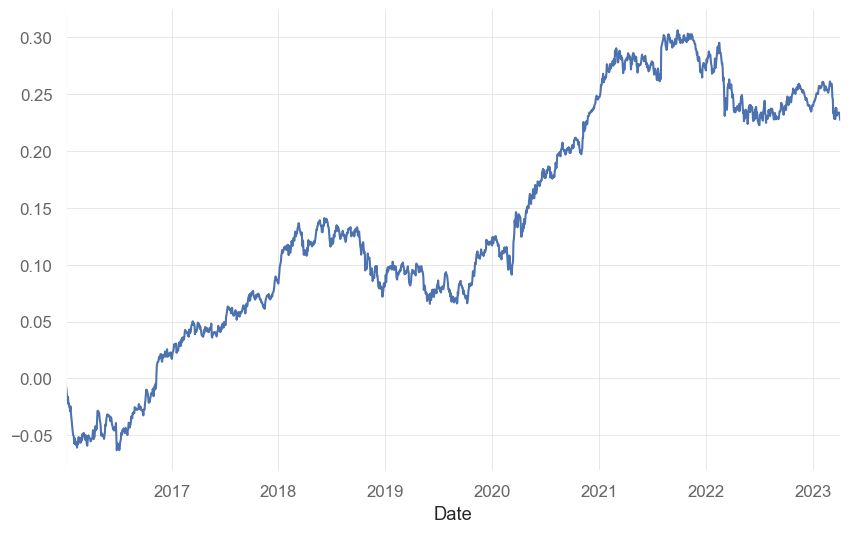

In [4]:
cash = balance_sheet['cash'].unstack().reindex_like(P).astype(float).ffill()
alpha = (cash / book).replace({np.inf:np.nan, - np.inf : np.nan})
signal = alpha.ffill()[P].copy()
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.001,0.99).apply(norm.ppf).loc['2016':]
signal = signal[signal.abs()>1]
# signal = signal.groupby(GICS['sector'],axis=1).apply(center)
signal = signal[P].sub(signal.mean(1),0)
signal = signal[P].div(signal.abs().sum(1),0)
pnl = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
pnl.cumsum().plot()
pd.Series({"sharpe":sharpe(pnl),
           'turnover':signal.diff().abs().sum().mean()*100,
           'biais' : pnl[pnl!=0].mean()*1e4})

In [5]:
tedrate = pd.read_csv('data/US/TEDRATE.csv')
tedrate = tedrate.set_index('DATE')
tedrate.index = pd.to_datetime(tedrate.index)
tedrate.index.name = 'Date'
# tedrate['TEDRATE'] = tedrate['TEDRATE'].astype(float)
tedrate = tedrate.replace({".":np.nan}).astype(float).ffill()
tedrate_monthly = tedrate.resample('MS').mean().shift().dropna()
tedrate_monthly_qcut = expanding_window_qcut(tedrate_monthly,'TEDRATE',5).dropna() + 1
constraint = np.sign(tedrate_monthly_qcut - 3).replace({0:np.nan}).dropna()

In [6]:
cash_ratio = cash / total_assets
cash_ratio = cash_ratio[cash_ratio>0].resample('MS').mean().shift()
cash_ratio = pd.DataFrame(cash_ratio.stack(),columns = ['CASH'])
cash_ratio

CASH
Date       Ticker          
2008-02-01 ADBE    0.165641
           APD     0.007415
           AYI     0.149628
           BBBY    0.049285
           BBY     0.085240
...                     ...
2023-04-01 YUM     0.062778
           ZBH     0.017834
           ZBRA    0.013946
           ZION    0.022302
           ZTS     0.239665

[125870 rows x 1 columns]

In [7]:
shares_out = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill()[P].astype(float)
close = market_data['close'].unstack().reindex_like(P).ffill()[P].astype(float)
mv = close * shares_out
rd = income_statement['researchDevelopment'].unstack().reindex_like(P).ffill()[P].astype(float)
rd_ratio = rd/ total_assets

book = balance_sheet['totalStockholderEquity'].unstack().reindex_like(P).ffill()[P].astype(float)
b_m = (book / mv).resample('MS').mean()
cf = cash_flow

In [8]:
R_monthly = pd.DataFrame(R.resample('MS').sum().rank(pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack())
R_monthly.columns = ['Y']

b_m = pd.DataFrame(b_m.resample('MS').mean().rank(pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack(),columns=['BM'])
rd_ratio = pd.DataFrame(rd_ratio.resample('MS').mean().rank(pct=True,ascending=True).clip(0.001,0.999).apply(norm.ppf).stack(),columns=['RD'])

In [9]:
from functools import reduce
data_frames = [R_monthly.shift(-1), constraint, cash_ratio, rd_ratio, b_m]
combined_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), data_frames)
combined_df = combined_df.replace({np.inf:np.nan, -np.inf:np.nan}).dropna()
combined_df

Y  TEDRATE_qcut      CASH        RD        BM
Date       Ticker                                                      
2008-02-01 MDT     1.233495           1.0  0.034046  1.339746 -2.134683
           NVDA   -1.150349           1.0  0.193979  0.786296 -0.213931
           STX    -1.294038           1.0  0.134985 -1.371145  1.117604
2008-03-01 ACN    -1.604083           1.0  0.236896 -0.201050 -1.650205
           ADBE    0.074997           1.0  0.165641  1.353725  0.440824
...                     ...           ...       ...       ...       ...
2022-01-01 XYL    -0.074997          -1.0  0.153969  0.152506 -1.382994
           YUM    -0.543252          -1.0  0.155943 -0.223425 -0.259071
           ZBH    -1.773856          -1.0  0.038303 -0.237647  0.302290
           ZBRA    0.799651          -1.0  0.052344  0.293381 -0.787876
           ZTS    -0.877095          -1.0  0.238891 -0.838697 -0.400858

[69511 rows x 5 columns]

In [10]:
%load_ext autoreload 
%autoreload 2
from econometrics import *
from utils import *
GICS.index.name = 'Ticker'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data = combined_df.join(GICS[['sector','gicind']]).swaplevel().dropna()
print(data )

                          Y  TEDRATE_qcut      CASH        RD        BM  \
Ticker Date                                                               
MDT    2008-02-01  1.233495           1.0  0.034046  1.339746 -2.134683   
NVDA   2008-02-01 -1.150349           1.0  0.193979  0.786296 -0.213931   
STX    2008-02-01 -1.294038           1.0  0.134985 -1.371145  1.117604   
ACN    2008-03-01 -1.604083           1.0  0.236896 -0.201050 -1.650205   
ADBE   2008-03-01  0.074997           1.0  0.165641  1.353725  0.440824   
...                     ...           ...       ...       ...       ...   
XYL    2022-01-01 -0.074997          -1.0  0.153969  0.152506 -1.382994   
YUM    2022-01-01 -0.543252          -1.0  0.155943 -0.223425 -0.259071   
ZBH    2022-01-01 -1.773856          -1.0  0.038303 -0.237647  0.302290   
ZBRA   2022-01-01  0.799651          -1.0  0.052344  0.293381 -0.787876   
ZTS    2022-01-01 -0.877095          -1.0  0.238891 -0.838697 -0.400858   

                        

In [12]:
df = data[['Y','CASH','RD','BM','sector']]

features = ['CASH','RD','BM']
df = center_and_standardize(df,features,1,True)
df_train = df.sort_index(level=0).loc[pd.IndexSlice[:, :'2018'], :]
Y_train = df_train['Y']
X_train = df_train.drop(['Y'],axis=1)

df_test = df.sort_index(level=0).loc[pd.IndexSlice[:, '2018':], :]
Y_test = df_test['Y']
X_test = df_test.drop(['Y'],axis=1)

In [13]:
endog = ['Y',"CASH"]
# Independent variables for each equation
exog = {
    'Y': ['BM', 'CASH'],
    "CASH":["RD"]
    
}
results = fit_sur_model(df_train[['Y',"CASH"]],df_train[['CASH','RD','BM']],add_constant=False,endog = endog, exog = exog)

results_sur = results.predict(equations = {"Y":{"exog":X_test[['BM','CASH']]},"CASH":{"exog":X_test[["RD"]]}})['Y']
results_sur

Ticker  Date      
A       2018-01-01    0.008942
        2018-02-01    0.009025
        2018-03-01    0.008656
        2018-05-01    0.009190
        2018-09-01    0.009565
                        ...   
ZTS     2021-09-01    0.005063
        2021-10-01    0.005074
        2021-11-01    0.004558
        2021-12-01    0.003473
        2022-01-01    0.005947
Name: Y, Length: 20445, dtype: float64

In [14]:
panel_ols = RegressionPanelOLS(Y_train,X_train,other_effect=['sector'],add_constant=True)
panel_ols.fit()
pred_panel = panel_ols.predict(X_test)
pred_panel

                   const      CASH        RD        BM      sector
Ticker Date                                                       
A      2018-01-01    1.0  2.198660 -1.611534 -0.068477  Healthcare
       2018-02-01    1.0  2.233671 -1.833513 -0.093902  Healthcare
       2018-03-01    1.0  2.282994 -1.329144 -0.329076  Healthcare
       2018-05-01    1.0  2.316948 -1.434878 -0.167907  Healthcare
       2018-09-01    1.0  2.496352 -0.165564 -0.318736  Healthcare
...                  ...       ...       ...       ...         ...
ZTS    2021-09-01    1.0  1.431704 -2.384529 -0.356279  Healthcare
       2021-10-01    1.0  1.432552 -2.380359 -0.353252  Healthcare
       2021-11-01    1.0  1.397200 -1.327133 -0.504921  Healthcare
       2021-12-01    1.0  1.305412 -1.154782 -0.794065  Healthcare
       2022-01-01    1.0  1.409765 -1.133556  0.043790  Healthcare

[20445 rows x 5 columns]
const    0.007515
CASH     0.008223
RD       0.005256
BM       0.003269
Name: parameter, dtype: float64

predictions
Ticker Date                   
A      2018-01-01    -0.001098
       2018-02-01    -0.002059
       2018-03-01     0.000228
       2018-05-01     0.000479
       2018-09-01     0.008132
...                        ...
ZTS    2021-09-01    -0.012408
       2021-10-01    -0.012369
       2021-11-01    -0.007620
       2021-12-01    -0.008414
       2022-01-01    -0.004706

[20445 rows x 1 columns]

In [15]:
res = fit_between_ols(Y_train,X_train,add_constant=True)
pred = res.predict(sm.add_constant(X_test))

res

Dep. Variable:,Y,R-squared:,0.0382
Estimator:,BetweenOLS,R-squared (Between):,0.0382
No. Observations:,595,R-squared (Within):,-0.0022
Date:,"Wed, May 29 2024",R-squared (Overall):,-0.0027
Time:,17:35:02,Log-likelihood,239.22
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.5326
Entities:,595,P-value,0.0886
Avg Obs:,88.950,Distribution:,"F(15,579)"
Min Obs:,1.0000,,
Max Obs:,114.00,F-statistic (robust):,1.5326


In [16]:
X_train

CASH        RD        BM      sector
Ticker Date                                                
A      2008-04-01  1.111473  1.579398  0.395807  Healthcare
       2008-05-01  1.112008  2.355798  0.329252  Healthcare
       2008-06-01  1.168942  2.277715  0.110127  Healthcare
       2008-07-01  1.477081  2.233538  0.022060  Healthcare
       2008-08-01  1.530710  2.167939  0.069460  Healthcare
...                     ...       ...       ...         ...
ZTS    2018-05-01  0.864994  0.042537 -0.165754  Healthcare
       2018-09-01  0.958745  0.460119 -0.472964  Healthcare
       2018-10-01  0.983564  0.450027 -0.940031  Healthcare
       2018-11-01  1.008278 -0.472799 -0.504538  Healthcare
       2018-12-01  0.415642 -0.463963 -0.348349  Healthcare

[52925 rows x 4 columns]

In [17]:
def qcut_features(df, features, level, q):
    def apply_qcut(group):
        # Apply qcut to each feature
        quantiled = group[features].apply(lambda x: pd.qcut(x, q, labels=False, duplicates='drop') + 1)
        return quantiled

    quantiled_df = df.groupby(level=level, group_keys=False).apply(apply_qcut)
    
    # Assign the quantile ranks back to the original dataframe
    for feature in features:
        df[feature] = quantiled_df[feature] +1
    
    return df



Y_qcut = qcut_features(df[['Y']],features = ['Y'],level=1,q=10)
Y_train_qcut = qcut_features(pd.DataFrame(Y_train,columns = ['Y']),features = ['Y'],level=1,q=10)

In [18]:
results = fit_multinomial_logit_model(Y_train_qcut,X_train[features],add_constant=True)

Optimization terminated successfully.
         Current function value: 2.301950
         Iterations 4


In [19]:
%load_ext autoreload 
%autoreload 2 
from econometrics import *
predict_multinomial_logit(results,X_test[features])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


predictions
Ticker Date                   
A      2018-01-01            0
       2018-02-01            0
       2018-03-01            0
       2018-05-01            0
       2018-09-01            0
...                        ...
ZTS    2021-09-01            0
       2021-10-01            0
       2021-11-01            0
       2021-12-01            0
       2022-01-01            0

[20445 rows x 1 columns]

In [179]:
'const' in results.params.index.tolist() and 'const' not in (X_test).columns.tolist()

True